# Notebook 3: Identifying Weather-Related Scrubs from Public Launch Records

## Objective
This notebook focuses on identifying **weather-related launch issues** using publicly
available SpaceX launch metadata. Because official scrub classifications are not
consistently provided, the goal is to construct a **conservative weather-issue label**
that can be used for exploratory analysis and as a baseline classification task.

This notebook does not attempt to fully reconstruct SpaceX’s launch commit criteria.
Instead, it isolates a small subset of launches that are explicitly described as
weather-impacted in public records.

---

## Motivation
Public launch data presents two challenges:
1. Weather-related scrubs are **rare** relative to successful launches.
2. Scrub reasons are often **ambiguous or incomplete**, with weather sometimes used as
   a public-facing explanation for technical or scheduling issues.

As a result, simple binary labels based on “scrub” or “no scrub” are unreliable.
This notebook adopts a **text-based filtering approach** that prioritizes precision
over recall.

---

## Data sources
This analysis uses:
- SpaceX launch metadata downloaded in Notebook 1
- Free-text launch descriptions (`details`) from the SpaceX API

No meteorological data are used in this notebook; the focus is purely on label
construction from metadata.

---

## Methodology: conservative text-based classification
Weather-related issues are identified using keyword-based filtering on launch
descriptions. Examples of keywords include:
- “weather”
- “winds”
- “clouds”
- “lightning”
- “range weather”

Only launches with **explicit references to weather** are labeled as
`weather_issue_flag = 1`. All others are labeled as 0.

This approach minimizes false positives at the expense of missing many implicit or
forecast-driven weather decisions.

---

## Results
The resulting dataset contains:
- A **very small number** of weather-issue cases
- A large majority of successful or non-weather-related launches

This extreme class imbalance limits the usefulness of this label for robust machine
learning, but it provides:
- A sanity check against known weather sensitivities
- A baseline classifier for comparison with severity-based approaches

---

## Limitations
- Many weather-driven schedule changes may not be labeled as weather in public records.
- Some “weather” scrubs may mask technical or operational issues.
- Keyword-based classification cannot capture nuanced decision-making.

For these reasons, the weather-issue label is used cautiously and primarily for
exploratory purposes.

---

## Role in the overall workflow
This notebook informs later modeling choices by demonstrating that:
- Direct weather-scrub classification is underconstrained by public data
- A more physically grounded severity-based approach (Notebook 4) is required

The weather-issue label remains useful as a qualitative reference and baseline, but
the primary launch-weather inference is performed using near-envelope modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

plt.style.use("seaborn-v0_8")

data_dir = Path("data")

df = pd.read_csv(
    data_dir / "spacex_era5_ksc_droneship_2010_2024.csv",
    parse_dates=["date_utc"]
)

df.head()

,id,name,date_utc,year,launchpad,rocket_name,launched_flag,weather_scrub_flag,details,date_hour,date_hour_utc_naive,time_hour,wind_speed_10m,t2m_C,tcc_frac,tp_mmhr,cp_mmhr,msl,swh
0,5eb87cddffd86e000604b32f,Falcon 9 Test Flight,2010-06-04 18:45:00+00:00,2010,5e9e4501f509094ba4566f84,Falcon 9,1.0,False,NaN,2010-06-04 18:00:00+00:00,2010-06-04 18:00:00,2010-06-04 18:00:00,1.900000,27.712921,0.495819,0.000000,0.000000,101518.875,0.903720
1,5eb87cdeffd86e000604b330,COTS 1,2010-12-08 15:43:00+00:00,2010,5e9e4501f509094ba4566f84,Falcon 9,1.0,False,NaN,2010-12-08 15:00:00+00:00,2010-12-08 15:00:00,2010-12-08 15:00:00,2.469445,12.554108,0.012634,0.000000,0.000000,102057.875,1.315865
2,5eb87cdfffd86e000604b331,COTS 2,2012-05-22 07:44:00+00:00,2012,5e9e4501f509094ba4566f84,Falcon 9,1.0,False,"Launch was scrubbed on first attempt, second l...",2012-05-22 07:00:00+00:00,2012-05-22 07:00:00,2012-05-22 07:00:00,3.432389,24.871124,0.000000,0.000000,0.000000,101460.690,1.165456
3,5eb87ce0ffd86e000604b332,CRS-1,2012-10-08 00:35:00+00:00,2012,5e9e4501f509094ba4566f84,Falcon 9,1.0,False,"CRS-1 successful, but the secondary payload wa...",2012-10-08 00:00:00+00:00,2012-10-08 00:00:00,2012-10-08 00:00:00,4.558444,26.949371,0.952881,0.005722,0.002384,101528.440,0.712928
4,5eb87ce1ffd86e000604b333,CRS-2,2013-03-01 19:10:00+00:00,2013,5e9e4501f509094ba4566f84,Falcon 9,1.0,False,Last launch of the original Falcon 9 v1.0 laun...,2013-03-01 19:00:00+00:00,2013-03-01 19:00:00,2013-03-01 19:00:00,4.783648,15.626373,0.942108,0.000000,0.000000,101402.250,1.537332


In [2]:
# Ensure we have a clean launch timestamp floored to hour
df["date_hour"] = df["date_utc"].dt.floor("h")
df["launch_hour"] = df["date_hour"].dt.hour
df["launch_month"] = df["date_hour"].dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return "DJF"
    elif m in [3, 4, 5]:
        return "MAM"
    elif m in [6, 7, 8]:
        return "JJA"
    else:
        return "SON"

df["season"] = df["launch_month"].apply(month_to_season)

df[["date_utc", "launch_hour", "launch_month", "season"]].head()


,date_utc,launch_hour,launch_month,season
0,2010-06-04 18:45:00+00:00,18,6,JJA
1,2010-12-08 15:43:00+00:00,15,12,DJF
2,2012-05-22 07:44:00+00:00,7,5,MAM
3,2012-10-08 00:35:00+00:00,0,10,SON
4,2013-03-01 19:10:00+00:00,19,3,MAM


In [3]:
def flag_any_scrub_or_failure(details: str) -> bool:
    if not isinstance(details, str):
        return False
    text = details.lower()
    keywords = [
        "scrub", "scrubbed", "abort", "aborted",
        "delayed", "delay", "postpone", "postponed",
        "failure", "failed", "anomaly",
    ]
    return any(kw in text for kw in keywords)

def classify_scrub_reason(details: str) -> str:
    if not isinstance(details, str):
        return "unknown"
    text = details.lower()

    weather_keywords = [
        "weather", "upper-level winds", "upper level winds",
        "lightning", "storm", "rain", "thick cloud",
        "cloud rule", "anvil", "cumulus", "unfavorable conditions",
    ]

    technical_keywords = [
        "engine", "merlin", "valve", "sensor", "pressur",
        "computer", "autosequence", "guidance", "leak",
        "fuel", "oxidizer", "fairing", "hardware", "propellant",
    ]

    range_keywords = [
        "range violation", "range held", "boat in", "ship in",
        "keep-out zone", "airspace", "danger zone",
    ]

    if any(kw in text for kw in weather_keywords):
        return "weather"
    if any(kw in text for kw in technical_keywords):
        return "technical"
    if any(kw in text for kw in range_keywords):
        return "range"
    return "unknown"

df["text_scrub_like"] = df["details"].apply(flag_any_scrub_or_failure)
df["scrub_reason"] = df["details"].apply(classify_scrub_reason)
df["weather_issue_flag"] = (df["scrub_reason"] == "weather").astype(int)

print("scrub_reason counts:")
print(df["scrub_reason"].value_counts())
print("\nweather_issue_flag counts:")
print(df["weather_issue_flag"].value_counts())


scrub_reason counts:
scrub_reason
unknown      134
technical     16
weather        4
Name: count, dtype: int64

weather_issue_flag counts:
weather_issue_flag
0    150
1      4
Name: count, dtype: int64


In [4]:
vars_core = [
    "wind_speed_10m",
    "t2m_C",
    "tcc_frac",
    "tp_mmhr",
    "cp_mmhr",
    "msl",
    "swh",
]

desc = df[vars_core].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T
desc

,count,mean,std,min,50%,90%,95%,99%,max
wind_speed_10m,154.0,5.084893,2.150937,0.514257,4.891597,7.852882,8.885924,9.579847,11.408995
t2m_C,154.0,23.396560,3.974060,12.554108,24.464691,27.798267,28.137690,28.686436,30.682404
tcc_frac,154.0,0.535979,0.375790,0.000000,0.541031,0.998328,1.000000,1.000000,1.000000
tp_mmhr,154.0,0.051622,0.167815,0.000000,0.000000,0.158787,0.260782,0.641971,1.554966
cp_mmhr,154.0,0.029903,0.139523,0.000000,0.000000,0.061417,0.135481,0.546467,1.505852
msl,154.0,101801.192760,360.261000,100928.440000,101748.437500,102308.758000,102495.218000,102706.883750,102741.250000
swh,154.0,1.393421,0.547299,0.519284,1.233202,2.061306,2.481961,3.196449,3.742998


In [9]:
percentile = 1
placards_df = df[vars_core].quantile(percentile).to_frame(name=f"{int(percentile*100)}th_percentile")
placards = placards_df.iloc[:, 0]  # this is now a Series
placards


wind_speed_10m        11.408995
t2m_C                 30.682404
tcc_frac               1.000000
tp_mmhr                1.554966
cp_mmhr                1.505852
msl               102741.250000
swh                    3.742998
Name: 100th_percentile, dtype: float64

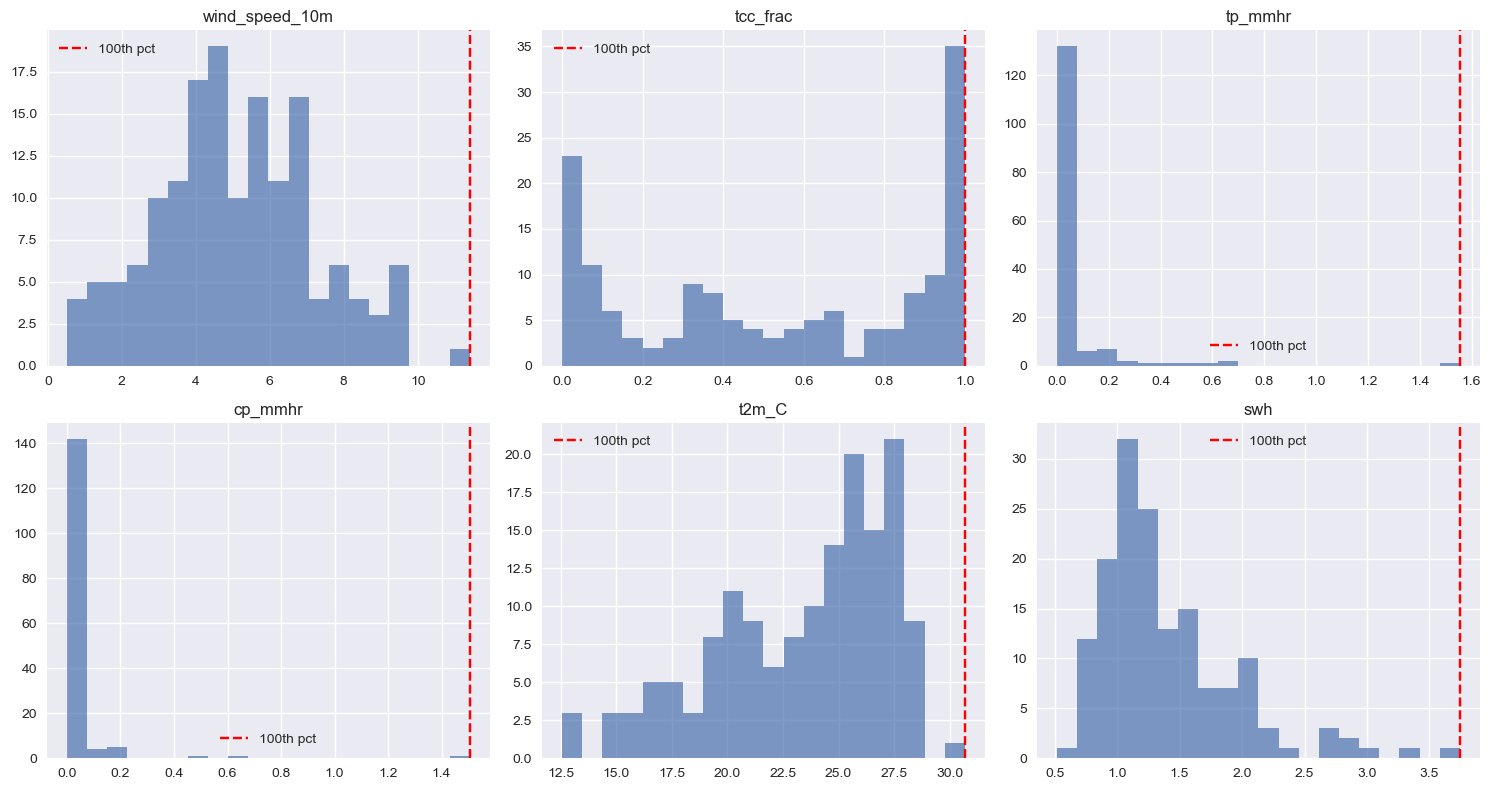

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for ax, var in zip(axes, ["wind_speed_10m", "tcc_frac", "tp_mmhr", "cp_mmhr", "t2m_C", "swh"]):
    ax.hist(df[var].dropna(), bins=20, alpha=0.7)
    thr = placards[var]
    ax.axvline(thr, color="red", linestyle="--", label=f"{int(percentile*100)}th pct")
    ax.set_title(var)
    ax.legend()

plt.tight_layout()
plt.show()

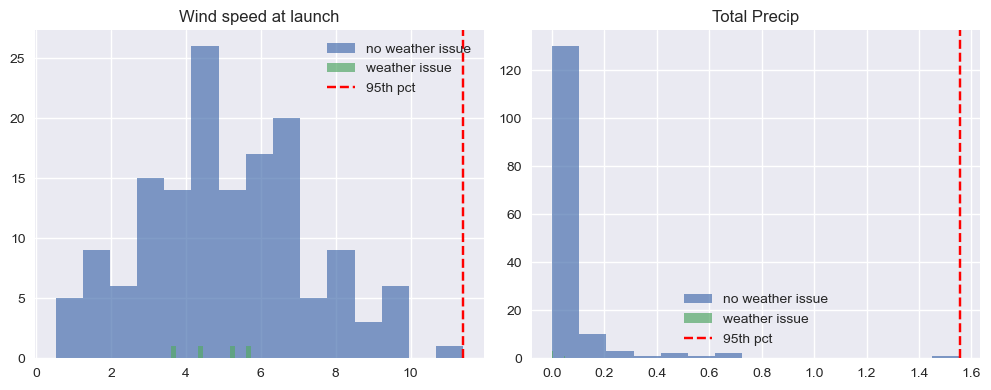

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df[df["weather_issue_flag"] == 0]["wind_speed_10m"].hist(
    bins=15, alpha=0.7, label="no weather issue", ax=axes[0]
)
df[df["weather_issue_flag"] == 1]["wind_speed_10m"].hist(
    bins=15, alpha=0.7, label="weather issue", ax=axes[0]
)
axes[0].axvline(placards["wind_speed_10m"], color="red", linestyle="--", label="95th pct")
axes[0].set_title("Wind speed at launch")
axes[0].legend()

df[df["weather_issue_flag"] == 0]["tp_mmhr"].hist(
    bins=15, alpha=0.7, label="no weather issue", ax=axes[1]
)
df[df["weather_issue_flag"] == 1]["tp_mmhr"].hist(
    bins=15, alpha=0.7, label="weather issue", ax=axes[1]
)
axes[1].axvline(placards["tp_mmhr"], color="red", linestyle="--", label="95th pct")
axes[1].set_title("Total Precip")
axes[1].legend()

plt.tight_layout()
plt.show()


In [14]:
# Normalize by 95th percentile, clip to avoid infinities
norm = placards.copy()

df["severity_score"] = (
    (df["wind_speed_10m"] / norm["wind_speed_10m"]) +
    (df["tcc_frac"] / norm["tcc_frac"]) +
    (df["tp_mmhr"] / (norm["tp_mmhr"] + 1e-6)) +
    (df["swh"] / (norm["swh"] + 1e-6))
)

df["severity_score"].describe()


count    154.000000
mean       1.387143
std        0.502242
min        0.346587
25%        0.988571
50%        1.457336
75%        1.724375
max        2.652950
Name: severity_score, dtype: float64

In [15]:
df["too_bad_flag"] = (df["severity_score"] > 4.0).astype(int)  # 4 ~ sum of 4 normals
df["too_bad_flag"].value_counts()

too_bad_flag
0    154
Name: count, dtype: int64

In [16]:
out_path = data_dir / "spacex_era5_ksc_droneship_2010_2024_enriched.csv"
df.to_csv(out_path, index=False)
print("Saved enriched dataset to:", out_path)

Saved enriched dataset to: data\spacex_era5_ksc_droneship_2010_2024_enriched.csv
